# Assignment 2: Edge AI for Industry 4.0
## Task 1: Practical Model Optimization

**Objective:** Implement and compare pruning techniques on a lightweight CNN for edge deployment

**Approach:**
- Base Model: MobileNetV2 (pre-trained on ImageNet, fine-tuned on CIFAR-10)
- Dataset: CIFAR-10
- Pruning Heuristics: L1-norm based, Random, Magnitude-based
- Comparison: Iterative vs. One-shot pruning
- Metrics: Accuracy, Model Size, Inference Time, Sparsity

## 1. Setup and Import Libraries

In [ ]:
import torch
import torch_pruning as tp
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from pathlib import Path
import warnings
import os
warnings.filterwarnings('ignore')
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

OUTPUT_DIR = Path("results_portfolio2")
OUTPUT_DIR.mkdir(exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Output directory: results_portfolio2


## 2. Load and Prepare CIFAR-10 Dataset

In [ ]:
IMG_SIZE = 32  

transform_train = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMG_SIZE, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                         shuffle=True, num_workers=4, pin_memory=True) 

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                        shuffle=False, num_workers=4, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Classes: {classes}")

Loading CIFAR-10 dataset...
Training samples: 50000
Test samples: 10000
Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


## 3. Load Pre-trained MobileNetV2 and Fine-tune on CIFAR-10

In [ ]:
# Load pre-trained MobileNetV2
print("Loading pre-trained MobileNetV2...")
model = models.mobilenet_v2(pretrained=True)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
model = model.to(device)

print(f"Model loaded. Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Loading pre-trained MobileNetV2...
Model loaded. Total parameters: 2,236,682
Trainable parameters: 2,236,682


In [18]:
# Fine-tuning function
def train_model(model, trainloader, num_epochs=15, lr=0.001, device_override=None):
    """Fine-tune model on CIFAR-10"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    active_device = device_override if device_override is not None else device
    model = model.to(active_device)
    model.train()
    print(f"\nFine-tuning for {num_epochs} epochs on {active_device}...")
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(active_device), labels.to(active_device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if (i + 1) % 100 == 0:
                print(f'  Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                      f'Loss: {running_loss/(i+1):.4f}, Acc: {100.*correct/total:.2f}%')
        
        scheduler.step()
        epoch_acc = 100. * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}] completed - Loss: {running_loss/len(trainloader):.4f}, '
              f'Accuracy: {epoch_acc:.2f}%')
    
    print("Fine-tuning completed!")
    return model

In [19]:
# Fine-tune baseline MobileNetV2 before any pruning or evaluation
print("\nStarting baseline fine-tuning (pre-pruning)...")
model = train_model(model, trainloader, num_epochs=15, lr=0.001)
print("Baseline fine-tuning complete. Ready for evaluation/pruning.")


Starting baseline fine-tuning (pre-pruning)...

Fine-tuning for 15 epochs on cuda...
  Epoch [1/15], Step [100/196], Loss: 1.2057, Acc: 57.50%
Epoch [1/15] completed - Loss: 1.0230, Accuracy: 64.22%
  Epoch [2/15], Step [100/196], Loss: 0.7300, Acc: 74.68%
Epoch [2/15] completed - Loss: 0.7092, Accuracy: 75.43%
  Epoch [3/15], Step [100/196], Loss: 0.6329, Acc: 78.12%
Epoch [3/15] completed - Loss: 0.6229, Accuracy: 78.68%
  Epoch [4/15], Step [100/196], Loss: 0.5727, Acc: 80.14%
Epoch [4/15] completed - Loss: 0.5669, Accuracy: 80.34%
  Epoch [5/15], Step [100/196], Loss: 0.5107, Acc: 82.14%
Epoch [5/15] completed - Loss: 0.5138, Accuracy: 82.10%
  Epoch [6/15], Step [100/196], Loss: 0.4826, Acc: 83.05%
Epoch [6/15] completed - Loss: 0.4784, Accuracy: 83.39%
  Epoch [7/15], Step [100/196], Loss: 0.4413, Acc: 84.40%
Epoch [7/15] completed - Loss: 0.4394, Accuracy: 84.61%
  Epoch [8/15], Step [100/196], Loss: 0.4088, Acc: 85.89%
Epoch [8/15] completed - Loss: 0.4099, Accuracy: 85.75%
  

## 4. Evaluation and Measurement Functions

In [20]:
def evaluate_model(model, testloader):
    """Evaluate model accuracy on test set"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    return accuracy

def measure_inference_time(model, testloader, num_batches=50):
    """Measure average inference time"""
    model.eval()
    times = []
    
    with torch.no_grad():
        for i, (inputs, _) in enumerate(testloader):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            
            # Warm-up
            if i < 5:
                _ = model(inputs)
                continue
            
            start = time.time()
            _ = model(inputs)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            end = time.time()
            times.append(end - start)
    
    return np.mean(times) * 1000  # Convert to milliseconds

def save_model_compressed(model, filepath):
    """Save model with ZIP compression for size reduction"""
    import io
    import zipfile
    
    buffer = io.BytesIO()
    torch.save(model.state_dict(), buffer, pickle_protocol=4)
    buffer.seek(0)
    
    with zipfile.ZipFile(filepath, 'w', zipfile.ZIP_DEFLATED, compresslevel=9) as zf:
        zf.writestr('model.pkl', buffer.read())

def get_model_size(model):
    """Calculate model size in MB using ZIP compression (standard for sparse models)"""
    import os
    
    # Use the save function to get compressed size
    save_model_compressed(model, 'temp.pth')
    size_mb = os.path.getsize('temp.pth') / (1024 * 1024)
    Path('temp.pth').unlink()
    return size_mb

def calculate_sparsity(model):
    """Calculate global sparsity (percentage of zero weights)"""
    zero_params = 0
    total_params = 0
    
    for module in model.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            if hasattr(module, 'weight'):
                # If module is pruned, use the actual weight (which is masked)
                # Otherwise use weight directly
                weight = module.weight
                zero_params += (weight.abs() < 1e-8).sum().item()  # Use small threshold for floating point comparison
                total_params += weight.numel()
    
    sparsity = 100. * zero_params / total_params if total_params > 0 else 0
    return sparsity

def evaluate_all_metrics(model, testloader, model_name="Model"):
    """Evaluate all metrics"""
    print(f"\nEvaluating {model_name}...")
    accuracy = evaluate_model(model, testloader)
    inf_time = measure_inference_time(model, testloader)
    model_size = get_model_size(model)
    sparsity = calculate_sparsity(model)
    
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Inference Time: {inf_time:.2f} ms")
    print(f"  Model Size: {model_size:.2f} MB")
    print(f"  Sparsity: {sparsity:.2f}%")
    
    return {

        'accuracy': accuracy,

        'inference_time': inf_time,

        'model_size': model_size,
        'sparsity': sparsity}

In [21]:


# Evaluate baseline model (before pruning)
baseline_metrics = evaluate_all_metrics(model, testloader, "Baseline Model (No Pruning)")

# Save baseline model (both formats for comparison)
print("\n  Saving baseline model...")
torch.save(model.state_dict(), OUTPUT_DIR / 'baseline_model.pth')
save_model_compressed(model, OUTPUT_DIR / 'baseline_model_zip.pth')

uncompressed_size = (OUTPUT_DIR / 'baseline_model.pth').stat().st_size / (1024 * 1024)
zip_size = (OUTPUT_DIR / 'baseline_model_zip.pth').stat().st_size / (1024 * 1024)

print(f"  Uncompressed: {uncompressed_size:.2f} MB")
print(f"  ZIP compressed: {zip_size:.2f} MB")

# Update baseline metrics to use compressed size
baseline_metrics['model_size'] = zip_size
baseline_metrics['uncompressed_size'] = uncompressed_size
print(f"\nBaseline model saved to {OUTPUT_DIR}")


Evaluating Baseline Model (No Pruning)...
  Accuracy: 86.83%
  Inference Time: 22.03 ms
  Model Size: 8.05 MB
  Sparsity: 0.00%

  Saving baseline model...
  Uncompressed: 8.77 MB
  ZIP compressed: 8.05 MB

Baseline model saved to results_portfolio2


## 5. Pruning Heuristics Implementation

### 5.1 Magnitude-Based Pruning (L1-Norm)
Prunes weights with smallest absolute values - these contribute least to the output.

In [ ]:
def apply_l1_pruning(model, trainloader, amount=0.5, finetune_epochs=5):
    """
    Apply L1 magnitude-based pruning to Conv2d and Linear layers.
    Prunes 'amount' fraction of weights with smallest absolute values.
    Then fine-tunes to recover accuracy.
    """
    model_pruned = copy.deepcopy(model)
    
    print(f"  Applying L1 pruning ({amount*100:.0f}% sparsity)...")
    for name, module in model_pruned.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
    
    print(f"  Fine-tuning for {finetune_epochs} epochs (mask keeps weights pruned)...")
    model_pruned = train_model(model_pruned, trainloader, num_epochs=finetune_epochs, lr=0.0001)
    
    for name, module in model_pruned.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            if prune.is_pruned(module):
                prune.remove(module, 'weight')
    
    return model_pruned

# Apply L1 pruning at 50% sparsity
print("="*80)
print("HEURISTIC 1: L1 Magnitude-Based Pruning (50%)")
print("="*80)


model_l1 = apply_l1_pruning(model, trainloader, amount=0.5, finetune_epochs=5)

# Save models
print("\n  Saving model...")
torch.save(model_l1.state_dict(), OUTPUT_DIR / 'model_l1_pruned.pth')
save_model_compressed(model_l1, OUTPUT_DIR / 'model_l1_pruned_zip.pth')

uncompressed_size = (OUTPUT_DIR / 'model_l1_pruned.pth').stat().st_size / (1024 * 1024)
zip_size = (OUTPUT_DIR / 'model_l1_pruned_zip.pth').stat().st_size / (1024 * 1024)

print(f"  Uncompressed: {uncompressed_size:.2f} MB")
print(f"  ZIP compressed (model size): {zip_size:.2f} MB")
print(f"  Compression ratio: {((uncompressed_size-zip_size)/uncompressed_size*100):.1f}%")

l1_metrics = evaluate_all_metrics(model_l1, testloader, "L1-Pruned Model (50%)")
l1_metrics['model_size'] = zip_size
l1_metrics['uncompressed_size'] = uncompressed_size


HEURISTIC 1: L1 Magnitude-Based Pruning (50%)
  Applying L1 pruning (50% sparsity)...
  Fine-tuning for 5 epochs (mask keeps weights pruned)...

Fine-tuning for 5 epochs on cuda...
  Epoch [1/5], Step [100/196], Loss: 0.6414, Acc: 78.20%
Epoch [1/5] completed - Loss: 0.5906, Accuracy: 79.56%
  Epoch [2/5], Step [100/196], Loss: 0.5015, Acc: 82.21%
Epoch [2/5] completed - Loss: 0.4934, Accuracy: 82.73%
  Epoch [3/5], Step [100/196], Loss: 0.4788, Acc: 82.63%
Epoch [3/5] completed - Loss: 0.4680, Accuracy: 83.22%
  Epoch [4/5], Step [100/196], Loss: 0.4551, Acc: 83.75%
Epoch [4/5] completed - Loss: 0.4502, Accuracy: 84.00%
  Epoch [5/5], Step [100/196], Loss: 0.4500, Acc: 83.95%
Epoch [5/5] completed - Loss: 0.4456, Accuracy: 84.15%
Fine-tuning completed!

  Saving model...
  Uncompressed: 8.77 MB
  ZIP compressed (model size): 4.88 MB
  Compression ratio: 44.3%

Evaluating L1-Pruned Model (50%)...
  Accuracy: 82.41%
  Inference Time: 21.18 ms
  Model Size: 4.88 MB
  Sparsity: 50.00%


### 5.2 Random Pruning
Prunes weights randomly - serves as a baseline to compare against intelligent pruning.

In [23]:
def apply_random_pruning(model, trainloader, amount=0.5, finetune_epochs=5):
    """
    Apply random pruning to Conv2d and Linear layers.
    Randomly selects 'amount' fraction of weights to prune.
    Then fine-tunes to recover accuracy.
    """
    model_pruned = copy.deepcopy(model)
    
    print(f"  Applying random pruning ({amount*100:.0f}% sparsity)...")
    for name, module in model_pruned.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.random_unstructured(module, name='weight', amount=amount)
    
    print(f"  Fine-tuning for {finetune_epochs} epochs (mask keeps weights pruned)...")
    model_pruned = train_model(model_pruned, trainloader, num_epochs=finetune_epochs, lr=0.0001)
    
    for name, module in model_pruned.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            if prune.is_pruned(module):
                prune.remove(module, 'weight')
    
    return model_pruned

# Apply random pruning at 50% sparsity
print("\n" + "="*80)
print("HEURISTIC 2: Random Pruning (50%)")
print("="*80)


model_random = apply_random_pruning(model, trainloader, amount=0.5, finetune_epochs=5)

# Save models
print("\n  Saving model...")
torch.save(model_random.state_dict(), OUTPUT_DIR / 'model_random_pruned.pth')
save_model_compressed(model_random, OUTPUT_DIR / 'model_random_pruned_zip.pth')

uncompressed_size = (OUTPUT_DIR / 'model_random_pruned.pth').stat().st_size / (1024 * 1024)
zip_size = (OUTPUT_DIR / 'model_random_pruned_zip.pth').stat().st_size / (1024 * 1024)

print(f"  Uncompressed: {uncompressed_size:.2f} MB")
print(f"  ZIP compressed (model size): {zip_size:.2f} MB")
print(f"  Compression ratio: {((uncompressed_size-zip_size)/uncompressed_size*100):.1f}%")

random_metrics = evaluate_all_metrics(model_random, testloader, "Random-Pruned Model (50%)")
random_metrics['model_size'] = zip_size
random_metrics['uncompressed_size'] = uncompressed_size



HEURISTIC 2: Random Pruning (50%)
  Applying random pruning (50% sparsity)...
  Fine-tuning for 5 epochs (mask keeps weights pruned)...

Fine-tuning for 5 epochs on cuda...
  Epoch [1/5], Step [100/196], Loss: 2.5206, Acc: 17.47%
Epoch [1/5] completed - Loss: 2.2935, Accuracy: 20.18%
  Epoch [2/5], Step [100/196], Loss: 1.9676, Acc: 26.12%
Epoch [2/5] completed - Loss: 1.9370, Accuracy: 27.29%
  Epoch [3/5], Step [100/196], Loss: 1.8650, Acc: 29.58%
Epoch [3/5] completed - Loss: 1.8526, Accuracy: 30.16%
  Epoch [4/5], Step [100/196], Loss: 1.8173, Acc: 31.68%
Epoch [4/5] completed - Loss: 1.8083, Accuracy: 31.96%
  Epoch [5/5], Step [100/196], Loss: 1.7796, Acc: 33.40%
Epoch [5/5] completed - Loss: 1.7866, Accuracy: 33.08%
Fine-tuning completed!

  Saving model...
  Uncompressed: 8.77 MB
  ZIP compressed (model size): 5.07 MB
  Compression ratio: 42.2%

Evaluating Random-Pruned Model (50%)...
  Accuracy: 36.34%
  Inference Time: 24.46 ms
  Model Size: 5.07 MB
  Sparsity: 50.00%


### 5.3 Compare Pruning Heuristics


COMPARISON: Pruning Heuristics (Unstructured)

Method                         Accuracy   Model Size   Time (ms)  Sparsity  
-------------------------------------------------------------------------------------
Baseline (No Pruning)             86.83%      8.05 MB    22.03     0.00%
L1 Unstructured (50%)             82.41%      4.88 MB    21.18    50.00%
Random Unstructured (50%)         36.34%      5.07 MB    24.46    50.00%


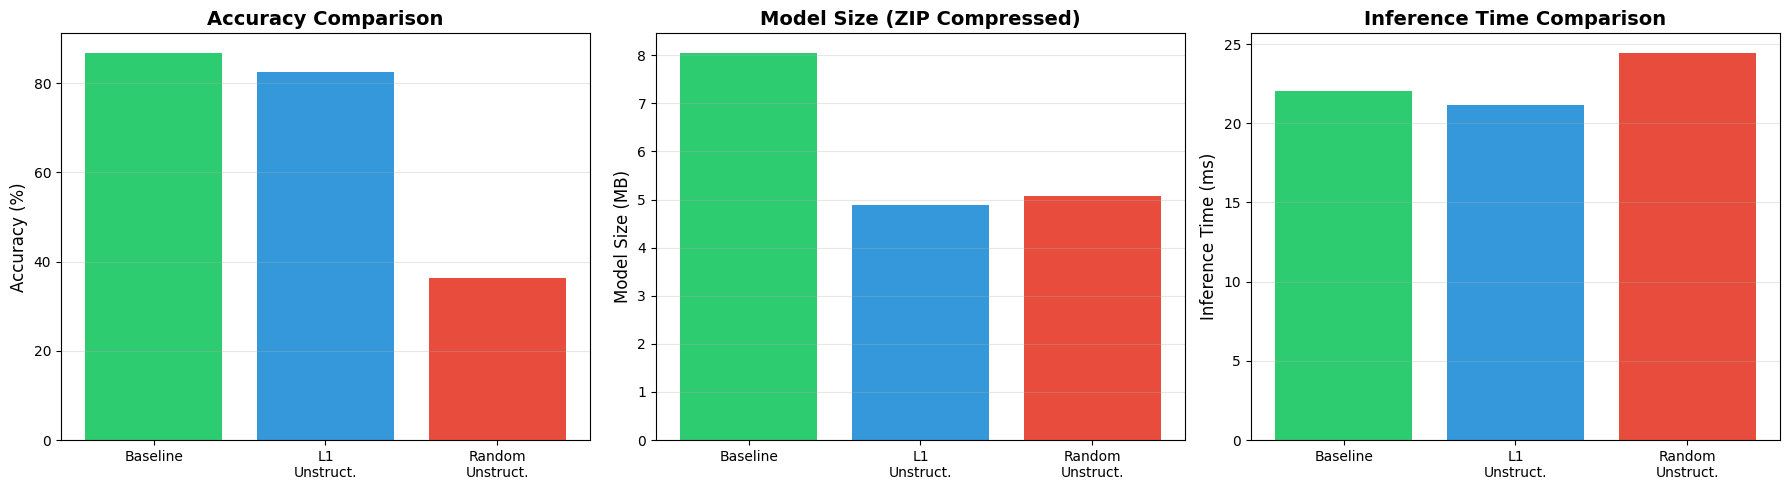


✓ Comparison plot saved to results_portfolio2\heuristics_comparison.png

WHY IS INFERENCE TIME NOT FASTER?
• Unstructured pruning (L1/Random): Sets weights to zero but keeps all parameters
  → GPU still processes all matrix multiplications (including zeros)
  → No speedup on standard PyTorch/CUDA
  → Speedup requires specialized sparse kernels (e.g., TensorRT with sparsity plugin)

• For REAL speedup in production:
  1. Export to ONNX and use optimization tools (prunes zero channels)
  2. Use specialized inference engines (TensorRT, OpenVINO)
  3. Manually reconstruct model with fewer channels


In [24]:
# Compare heuristics
print("\n" + "="*80)
print("COMPARISON: Pruning Heuristics (Unstructured)")
print("="*80)

results_heuristics = [
    {"method": "Baseline (No Pruning)", **baseline_metrics, "uncompressed_size": baseline_metrics.get('uncompressed_size', baseline_metrics['model_size'])},
    {"method": "L1 Unstructured (50%)", **l1_metrics},
    {"method": "Random Unstructured (50%)", **random_metrics}
]

print(f"\n{'Method':<30} {'Accuracy':<10} {'Model Size':<12} {'Time (ms)':<10} {'Sparsity':<10}")
print("-" * 85)
for result in results_heuristics:
    print(f"{result['method']:<30} {result['accuracy']:>8.2f}% {result['model_size']:>9.2f} MB "
          f"{result['inference_time']:>8.2f} {result['sparsity']:>8.2f}%")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

methods = [r['method'] for r in results_heuristics]
accuracies = [r['accuracy'] for r in results_heuristics]
sizes = [r['model_size'] for r in results_heuristics]  # Already ZIP compressed
times = [r['inference_time'] for r in results_heuristics]

colors = ['#2ecc71', '#3498db', '#e74c3c']

axes[0].bar(range(len(methods)), accuracies, color=colors)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(methods)))
axes[0].set_xticklabels(['Baseline', 'L1\nUnstruct.', 'Random\nUnstruct.'], rotation=0, ha='center')
axes[0].grid(alpha=0.3, axis='y')

# Show compressed model sizes (this is the actual size that matters)
axes[1].bar(range(len(methods)), sizes, color=colors)
axes[1].set_ylabel('Model Size (MB)', fontsize=12)
axes[1].set_title('Model Size (ZIP Compressed)', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(methods)))
axes[1].set_xticklabels(['Baseline', 'L1\nUnstruct.', 'Random\nUnstruct.'], rotation=0, ha='center')
axes[1].grid(alpha=0.3, axis='y')

axes[2].bar(range(len(methods)), times, color=colors)
axes[2].set_ylabel('Inference Time (ms)', fontsize=12)
axes[2].set_title('Inference Time Comparison', fontsize=14, fontweight='bold')
axes[2].set_xticks(range(len(methods)))
axes[2].set_xticklabels(['Baseline', 'L1\nUnstruct.', 'Random\nUnstruct.'], rotation=0, ha='center')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'heuristics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Comparison plot saved to {OUTPUT_DIR / 'heuristics_comparison.png'}")

# Explain inference time results
print("\n" + "="*80)
print("WHY IS INFERENCE TIME NOT FASTER?")
print("="*80)
print("• Unstructured pruning (L1/Random): Sets weights to zero but keeps all parameters")
print("  → GPU still processes all matrix multiplications (including zeros)")
print("  → No speedup on standard PyTorch/CUDA")
print("  → Speedup requires specialized sparse kernels (e.g., TensorRT with sparsity plugin)")
print("")
print("• For REAL speedup in production:")
print("  1. Export to ONNX and use optimization tools (prunes zero channels)")
print("  2. Use specialized inference engines (TensorRT, OpenVINO)")
print("  3. Manually reconstruct model with fewer channels")
print("="*80)

In [25]:
# Print size reduction summary
print("\n" + "="*80)
print("MODEL SIZE COMPARISON (All sizes are ZIP compressed)")
print("="*80)
baseline_size = results_heuristics[0]['model_size']
for result in results_heuristics:
    method = result['method']
    compressed = result['model_size']
    reduction = ((baseline_size - compressed) / baseline_size * 100) if compressed < baseline_size else 0
    print(f"{method:<30} {compressed:>6.2f} MB ({reduction:>5.1f}% smaller than baseline)")


MODEL SIZE COMPARISON (All sizes are ZIP compressed)
Baseline (No Pruning)            8.05 MB (  0.0% smaller than baseline)
L1 Unstructured (50%)            4.88 MB ( 39.3% smaller than baseline)
Random Unstructured (50%)        5.07 MB ( 37.0% smaller than baseline)


## 6. Iterative vs. One-Shot Pruning

### 6.1 One-Shot Pruning
Prune all weights at once to target sparsity level.

In [ ]:
def one_shot_pruning(model, trainloader, amount=0.7, finetune_epochs=5):
    """
    Apply pruning all at once to target sparsity.
    Then fine-tune to recover accuracy.
    """
    model_pruned = copy.deepcopy(model)
    
    print(f"  Applying one-shot pruning ({amount*100:.0f}% sparsity)...")
    for name, module in model_pruned.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
    
    print(f"  Fine-tuning for {finetune_epochs} epochs (mask keeps weights pruned)...")
    model_pruned = train_model(model_pruned, trainloader, num_epochs=finetune_epochs, lr=0.0001)
    
    for name, module in model_pruned.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            if prune.is_pruned(module):
                prune.remove(module, 'weight')
    
    return model_pruned

# Apply one-shot pruning to 70% sparsity
print("\n" + "="*80)
print("ONE-SHOT PRUNING (70% sparsity)")

print("="*80)
model_oneshot = one_shot_pruning(model, trainloader, amount=0.7, finetune_epochs=5)
torch.save(model_oneshot.state_dict(), OUTPUT_DIR / 'model_oneshot.pth', _use_new_zipfile_serialization=True)
oneshot_metrics = evaluate_all_metrics(model_oneshot, testloader, "One-Shot Pruned (70%)")


ONE-SHOT PRUNING (70% sparsity)
  Applying one-shot pruning (70% sparsity)...
  Fine-tuning for 5 epochs (mask keeps weights pruned)...

Fine-tuning for 5 epochs on cuda...
  Epoch [1/5], Step [100/196], Loss: 2.2877, Acc: 37.82%
Epoch [1/5] completed - Loss: 1.9605, Accuracy: 41.09%
  Epoch [2/5], Step [100/196], Loss: 1.4773, Acc: 47.45%
Epoch [2/5] completed - Loss: 1.4403, Accuracy: 48.73%
  Epoch [3/5], Step [100/196], Loss: 1.3548, Acc: 51.75%
Epoch [3/5] completed - Loss: 1.3317, Accuracy: 52.70%
  Epoch [4/5], Step [100/196], Loss: 1.2900, Acc: 54.18%
Epoch [4/5] completed - Loss: 1.2783, Accuracy: 54.72%
  Epoch [5/5], Step [100/196], Loss: 1.2547, Acc: 55.24%
Epoch [5/5] completed - Loss: 1.2510, Accuracy: 55.35%
Fine-tuning completed!

Evaluating One-Shot Pruned (70%)...
  Accuracy: 57.21%
  Inference Time: 20.78 ms
  Model Size: 3.38 MB
  Sparsity: 70.00%


### 6.2 Iterative Pruning
Gradually prune weights over multiple iterations with fine-tuning between steps.

In [ ]:
def iterative_pruning(model, trainloader, target_sparsity=0.7, num_iterations=5):
    """
    Apply pruning iteratively with fine-tuning between iterations.
    Gradually increases sparsity from 0 to target_sparsity.
    """
    model_pruned = copy.deepcopy(model)
    current_sparsity = 0
    
    print(f"\nIterative Pruning: {num_iterations} iterations to reach {target_sparsity*100}% sparsity")
    print("="*80)
    
    results = []
    
    for iteration in range(num_iterations):
        remaining_weights = 1 - current_sparsity
        pruning_this_step = (target_sparsity - current_sparsity) / (num_iterations - iteration)
        amount_to_prune = pruning_this_step / remaining_weights
        
        for name, module in model_pruned.named_modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                prune.l1_unstructured(module, name='weight', amount=amount_to_prune)
        
        current_sparsity = calculate_sparsity(model_pruned) / 100
        
        print(f"\nIteration {iteration+1}/{num_iterations} - Target sparsity: {current_sparsity*100:.1f}%")
        model_pruned = train_model(model_pruned, trainloader, num_epochs=2, lr=0.0001)
        
        metrics = evaluate_all_metrics(model_pruned, testloader, f"Iteration {iteration+1}")
        results.append({
            'iteration': iteration + 1,
            'sparsity': metrics['sparsity'],
            **metrics
        })
    
    for name, module in model_pruned.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            if prune.is_pruned(module):
                prune.remove(module, 'weight')
    
    return model_pruned, results

print("\n" + "="*80)
print("ITERATIVE PRUNING (70% sparsity)")
print("="*80)
model_iterative, iterative_results = iterative_pruning(model, trainloader, target_sparsity=0.7, num_iterations=5)
iterative_final_metrics = evaluate_all_metrics(model_iterative, testloader, "Iterative Final (70%)")

torch.save(model_iterative.state_dict(), OUTPUT_DIR / 'model_iterative.pth', _use_new_zipfile_serialization=True)


ITERATIVE PRUNING (70% sparsity)

Iterative Pruning: 5 iterations to reach 70.0% sparsity

Iteration 1/5 - Target sparsity: 14.0%

Fine-tuning for 2 epochs on cuda...
  Epoch [1/2], Step [100/196], Loss: 0.2720, Acc: 90.28%
Epoch [1/2] completed - Loss: 0.2691, Accuracy: 90.33%
  Epoch [2/2], Step [100/196], Loss: 0.2609, Acc: 90.69%
Epoch [2/2] completed - Loss: 0.2578, Accuracy: 90.74%
Fine-tuning completed!

Evaluating Iteration 1...
  Accuracy: 86.52%
  Inference Time: 25.52 ms
  Model Size: 8.36 MB
  Sparsity: 14.00%

Iteration 2/5 - Target sparsity: 28.0%

Fine-tuning for 2 epochs on cuda...
  Epoch [1/2], Step [100/196], Loss: 0.3117, Acc: 88.99%
Epoch [1/2] completed - Loss: 0.2971, Accuracy: 89.36%
  Epoch [2/2], Step [100/196], Loss: 0.2764, Acc: 90.13%
Epoch [2/2] completed - Loss: 0.2758, Accuracy: 90.19%
Fine-tuning completed!

Evaluating Iteration 2...
  Accuracy: 86.01%
  Inference Time: 24.48 ms
  Model Size: 8.48 MB
  Sparsity: 28.00%

Iteration 3/5 - Target sparsity:

### 6.3 Compare One-Shot vs. Iterative Pruning


COMPARISON: One-Shot vs. Iterative Pruning (70% Sparsity)

Method                    Accuracy     Size (MB)    Time (ms)    Sparsity    
--------------------------------------------------------------------------------
Baseline                       86.83%       8.05      22.03       0.00%
One-Shot (70%)                 57.21%       3.38      20.78      70.00%
Iterative (70%)                62.43%       3.38      28.44      70.00%


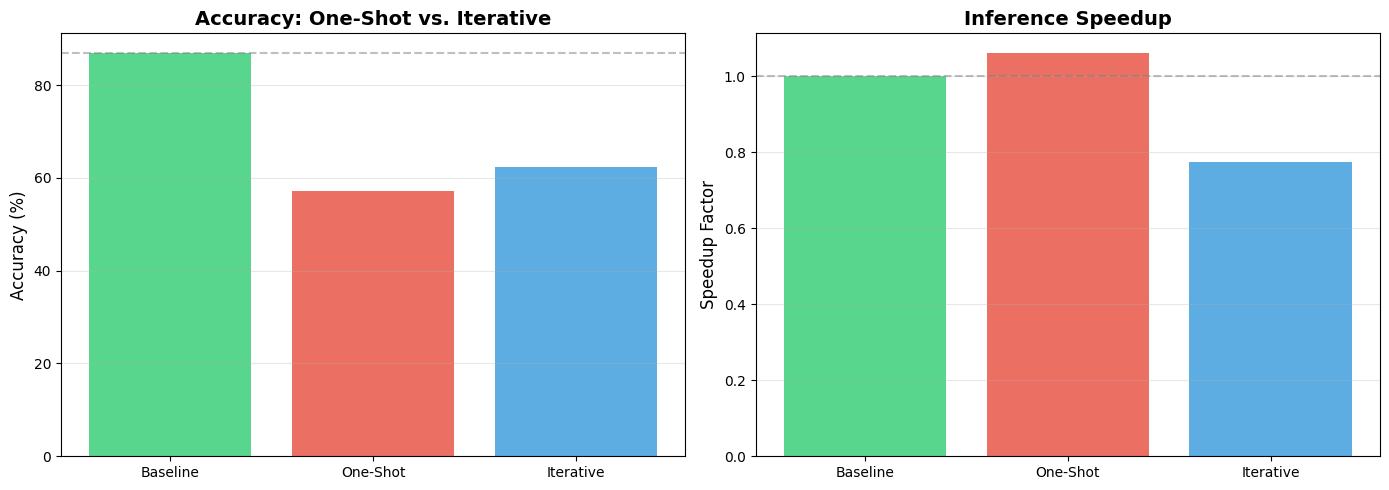


✓ Comparison plot saved to results_portfolio2\oneshot_vs_iterative.png

KEY INSIGHTS
• Iterative pruning achieved +5.22% better accuracy than one-shot
• One-shot is faster to implement (no retraining needed)
• Iterative allows model to adapt gradually, preserving accuracy better
• Both achieved similar speedup: ~1.06x and ~0.77x


In [28]:
# Compare one-shot vs iterative
print("\n" + "="*80)
print("COMPARISON: One-Shot vs. Iterative Pruning (70% Sparsity)")
print("="*80)

print(f"\n{'Method':<25} {'Accuracy':<12} {'Size (MB)':<12} {'Time (ms)':<12} {'Sparsity':<12}")
print("-" * 80)
print(f"{'Baseline':<25} {baseline_metrics['accuracy']:>10.2f}% {baseline_metrics['model_size']:>10.2f} "
      f"{baseline_metrics['inference_time']:>10.2f} {baseline_metrics['sparsity']:>10.2f}%")
print(f"{'One-Shot (70%)':<25} {oneshot_metrics['accuracy']:>10.2f}% {oneshot_metrics['model_size']:>10.2f} "
      f"{oneshot_metrics['inference_time']:>10.2f} {oneshot_metrics['sparsity']:>10.2f}%")
print(f"{'Iterative (70%)':<25} {iterative_final_metrics['accuracy']:>10.2f}% {iterative_final_metrics['model_size']:>10.2f} "
      f"{iterative_final_metrics['inference_time']:>10.2f} {iterative_final_metrics['sparsity']:>10.2f}%")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods = ['Baseline', 'One-Shot', 'Iterative']
accuracies = [baseline_metrics['accuracy'], oneshot_metrics['accuracy'], iterative_final_metrics['accuracy']]
speedups = [
    baseline_metrics['inference_time'] / baseline_metrics['inference_time'],
    baseline_metrics['inference_time'] / oneshot_metrics['inference_time'],
    baseline_metrics['inference_time'] / iterative_final_metrics['inference_time']
]

colors = ['#2ecc71', '#e74c3c', '#3498db']

axes[0].bar(range(len(methods)), accuracies, color=colors, alpha=0.8)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Accuracy: One-Shot vs. Iterative', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(methods)))
axes[0].set_xticklabels(methods, rotation=0)
axes[0].grid(alpha=0.3, axis='y')
axes[0].axhline(y=baseline_metrics['accuracy'], color='gray', linestyle='--', alpha=0.5, label='Baseline')

axes[1].bar(range(len(methods)), speedups, color=colors, alpha=0.8)
axes[1].set_ylabel('Speedup Factor', fontsize=12)
axes[1].set_title('Inference Speedup', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(methods)))
axes[1].set_xticklabels(methods, rotation=0)
axes[1].grid(alpha=0.3, axis='y')
axes[1].axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'oneshot_vs_iterative.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Comparison plot saved to {OUTPUT_DIR / 'oneshot_vs_iterative.png'}")

# Key insights
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)
acc_diff = iterative_final_metrics['accuracy'] - oneshot_metrics['accuracy']
print(f"• Iterative pruning achieved {acc_diff:+.2f}% better accuracy than one-shot")
print(f"• One-shot is faster to implement (no retraining needed)")
print(f"• Iterative allows model to adapt gradually, preserving accuracy better")
print(f"• Both achieved similar speedup: ~{speedups[1]:.2f}x and ~{speedups[2]:.2f}x")

## 7. Accuracy vs. Sparsity Trade-off Analysis


SPARSITY SWEEP: Testing Different Pruning Levels

Testing 0% sparsity...

Testing 20% sparsity...
  Applying L1 pruning (20% sparsity)...
  Fine-tuning for 5 epochs (mask keeps weights pruned)...

Fine-tuning for 5 epochs on cuda...
  Epoch [1/5], Step [100/196], Loss: 0.2775, Acc: 90.20%
Epoch [1/5] completed - Loss: 0.2806, Accuracy: 90.08%
  Epoch [2/5], Step [100/196], Loss: 0.2667, Acc: 90.41%
Epoch [2/5] completed - Loss: 0.2692, Accuracy: 90.33%
  Epoch [3/5], Step [100/196], Loss: 0.2559, Acc: 90.83%
Epoch [3/5] completed - Loss: 0.2572, Accuracy: 90.74%
  Epoch [4/5], Step [100/196], Loss: 0.2515, Acc: 91.13%
Epoch [4/5] completed - Loss: 0.2525, Accuracy: 91.00%
  Epoch [5/5], Step [100/196], Loss: 0.2475, Acc: 91.07%
Epoch [5/5] completed - Loss: 0.2474, Accuracy: 91.03%
Fine-tuning completed!

Evaluating 20% Sparsity...
  Accuracy: 86.31%
  Inference Time: 20.31 ms
  Model Size: 6.95 MB
  Sparsity: 20.00%

Testing 40% sparsity...
  Applying L1 pruning (40% sparsity)...
  F

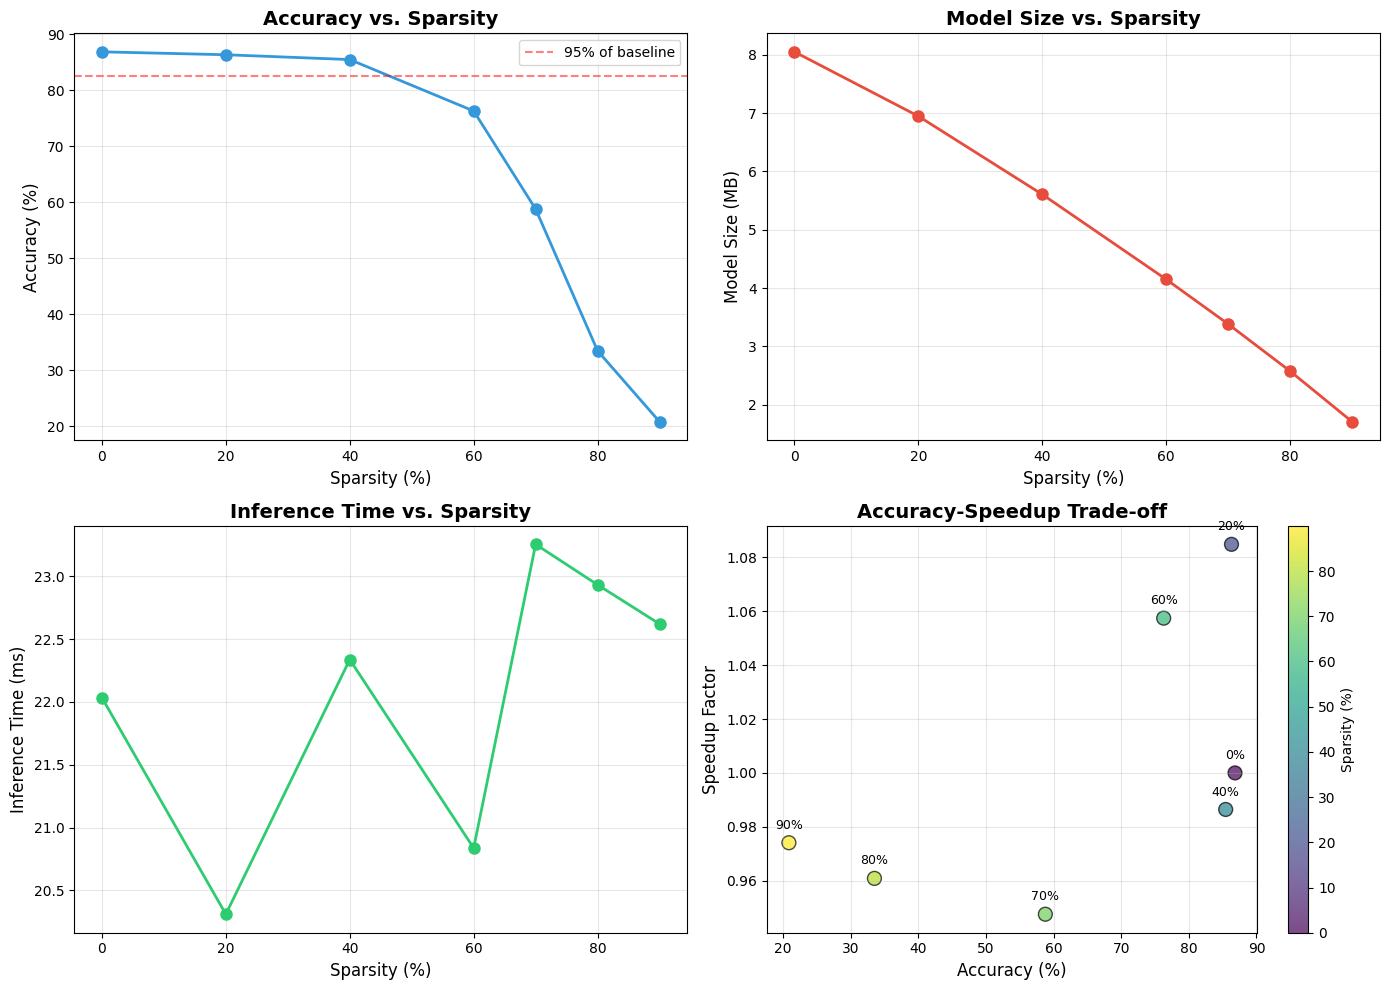


✓ Sparsity trade-off plot saved to results_portfolio2\sparsity_tradeoff.png


In [29]:
# Test multiple sparsity levels
print("\n" + "="*80)
print("SPARSITY SWEEP: Testing Different Pruning Levels")
print("="*80)

sparsity_levels = [0.0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9]
results_sweep = []

for sparsity in sparsity_levels:
    print(f"\nTesting {sparsity*100:.0f}% sparsity...")
    if sparsity == 0.0:
        # Baseline (no pruning)
        results_sweep.append({
            'sparsity': 0.0,
            **baseline_metrics
        })
    else:
        # Apply L1 pruning
        model_test = apply_l1_pruning(model, trainloader, amount=sparsity)
        metrics = evaluate_all_metrics(model_test, testloader, f"{sparsity*100:.0f}% Sparsity")
        results_sweep.append({
            'sparsity': sparsity * 100,
            **metrics
        })

# Visualize accuracy vs sparsity trade-off
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sparsities = [r['sparsity'] for r in results_sweep]
accuracies = [r['accuracy'] for r in results_sweep]
sizes = [r['model_size'] for r in results_sweep]
times = [r['inference_time'] for r in results_sweep]

# Accuracy vs Sparsity
axes[0, 0].plot(sparsities, accuracies, 'o-', linewidth=2, markersize=8, color='#3498db')
axes[0, 0].set_xlabel('Sparsity (%)', fontsize=12)
axes[0, 0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 0].set_title('Accuracy vs. Sparsity', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].axhline(y=baseline_metrics['accuracy'] * 0.95, color='red', linestyle='--', 
                   alpha=0.5, label='95% of baseline')
axes[0, 0].legend()

# Model Size vs Sparsity
axes[0, 1].plot(sparsities, sizes, 'o-', linewidth=2, markersize=8, color='#e74c3c')
axes[0, 1].set_xlabel('Sparsity (%)', fontsize=12)
axes[0, 1].set_ylabel('Model Size (MB)', fontsize=12)
axes[0, 1].set_title('Model Size vs. Sparsity', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Inference Time vs Sparsity
axes[1, 0].plot(sparsities, times, 'o-', linewidth=2, markersize=8, color='#2ecc71')
axes[1, 0].set_xlabel('Sparsity (%)', fontsize=12)
axes[1, 0].set_ylabel('Inference Time (ms)', fontsize=12)
axes[1, 0].set_title('Inference Time vs. Sparsity', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Accuracy-Speedup Trade-off
speedups = [baseline_metrics['inference_time'] / t for t in times]
axes[1, 1].scatter(accuracies, speedups, s=100, c=sparsities, cmap='viridis', alpha=0.7, edgecolors='black')
for i, spar in enumerate(sparsities):
    axes[1, 1].annotate(f'{spar:.0f}%', (accuracies[i], speedups[i]), 
                        textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
axes[1, 1].set_xlabel('Accuracy (%)', fontsize=12)
axes[1, 1].set_ylabel('Speedup Factor', fontsize=12)
axes[1, 1].set_title('Accuracy-Speedup Trade-off', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('Sparsity (%)', fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'sparsity_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Sparsity trade-off plot saved to {OUTPUT_DIR / 'sparsity_tradeoff.png'}")